<a href="https://colab.research.google.com/github/EstebanPerez25/Proyecto-Final-IDM/blob/main/Topological_Data_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Topological Data Analysis

Team: Idememes

* Javier Hernández Arellano
* Leonardo Laureles Olmedo
* Bernardo de Jesús Ortiz Rodriguez
* Itzel Yacquelin Beltrán Reyes
* Esteban Ángel Pérez Mauraira

### Libraries

In [ ]:
!pip install kmapper ripser giotto-tda

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import kmapper as km
from ripser import ripser
from persim import plot_diagrams
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from gtda.homology import VietorisRipsPersistence
from gtda.diagrams import PersistenceEntropy
from gtda.plotting import plot_diagram, plot_heatmap

### Load data

In [4]:
df_fe = pd.read_parquet('reservaciones_eda.parquet')

numeric_columns = df_fe.select_dtypes(include=['int64', 'float64']).columns
bool_columns = df_fe.select_dtypes(include=['bool']).columns
date_columns = df_fe.select_dtypes(include=['datetime64[ns]']).columns
categorical_columns = df_fe.select_dtypes(include=['category']).columns

df_fe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 203002 entries, 0 to 203001
Data columns (total 49 columns):
 #   Column                            Non-Null Count   Dtype         
---  ------                            --------------   -----         
 0   id_reservaciones                  203002 non-null  int64         
 1   fecha_hoy                         203002 non-null  datetime64[ns]
 2   fecha_reservacion                 203002 non-null  datetime64[ns]
 3   fecha_llegada                     203000 non-null  datetime64[ns]
 4   fecha_salida                      202968 non-null  datetime64[ns]
 5   numero_personas                   203002 non-null  int64         
 6   numero_personas_anio_anterior     203002 non-null  int64         
 7   numero_adultos                    203002 non-null  int64         
 8   numero_adultos_anio_anterior      203002 non-null  int64         
 9   numero_menores                    203002 non-null  int64         
 10  numero_menores_anio_anterior    

## Data Processing

First, we tried applying the following TDA tools to our fully processed dataset (after feature engineering), but the results were very poor and the processing times were long due to the large number of columns. Therefore, we decided to use our original dataset, applying less preprocessing.

In [22]:
import warnings
warnings.filterwarnings('ignore')

df_tda = df_fe.copy()

# Drop datetime and categorical columns (we have the ids)
df_tda.drop(columns=date_columns, axis=1, inplace=True)
df_tda.drop(columns=categorical_columns, axis=1, inplace=True)
df_tda.drop(columns=['id_reservaciones'], axis=1, inplace=True)


# Change bool to int
df_tda[bool_columns] = df_tda[bool_columns].astype(int)

# Min Max Scaler, for range between 0 and 1
scaler = MinMaxScaler()
df_tda[:] = scaler.fit_transform(df_tda[:])

# Drop NA (Small amount)
df_tda.dropna(axis=0, inplace=True)


df_tda.info()

<class 'pandas.core.frame.DataFrame'>
Index: 202992 entries, 0 to 203001
Data columns (total 28 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   numero_personas                   202992 non-null  float64
 1   numero_personas_anio_anterior     202992 non-null  float64
 2   numero_adultos                    202992 non-null  float64
 3   numero_adultos_anio_anterior      202992 non-null  float64
 4   numero_menores                    202992 non-null  float64
 5   numero_menores_anio_anterior      202992 non-null  float64
 6   numero_noches                     202992 non-null  float64
 7   numero_noches_anio_anterior       202992 non-null  float64
 8   total_habitaciones                202992 non-null  float64
 9   total_habitaciones_anio_anterior  202992 non-null  float64
 10  id_programa                       202992 non-null  int64  
 11  id_paquete                        202992 non-null  float6

In [6]:
df_tda.head()

,numero_personas,numero_personas_anio_anterior,numero_adultos,numero_adultos_anio_anterior,numero_menores,numero_menores_anio_anterior,numero_noches,numero_noches_anio_anterior,total_habitaciones,total_habitaciones_anio_anterior,...,id_canal,id_pais_origen,reservacion_pendiente,id_estatus_reservacion,total_tarifa,id_moneda,reservacion,reservacion_anio_anterior,id_cliente_disp,cliente_disp_anio_anterior
0,0.0625,0.0,0.133333,0.0,0.0,0.0,0.004367,0.0,0.166667,0.0,...,0.769231,0.676724,1,1.0,0.031552,0,1,0,0.133333,0.0
1,0.1250,0.0,0.266667,0.0,0.0,0.0,0.005822,0.0,0.166667,0.0,...,0.769231,0.676724,1,1.0,0.030710,0,1,0,0.266667,0.0
2,0.0625,0.0,0.133333,0.0,0.0,0.0,0.005822,0.0,0.166667,0.0,...,0.769231,0.676724,1,1.0,0.031552,0,1,0,0.133333,0.0
3,0.1250,0.0,0.200000,0.0,0.0,0.0,0.004367,0.0,0.166667,0.0,...,0.769231,0.676724,1,1.0,0.030927,0,1,0,0.200000,0.0
4,0.0625,0.0,0.133333,0.0,0.0,0.0,0.005822,0.0,0.166667,0.0,...,1.000000,0.676724,1,1.0,0.041618,0,1,0,0.133333,0.0


## Persistence Diagrams and Mapper Algorithms

### 1. Original data

Raw data after feature engineering.

#### Persistent homology

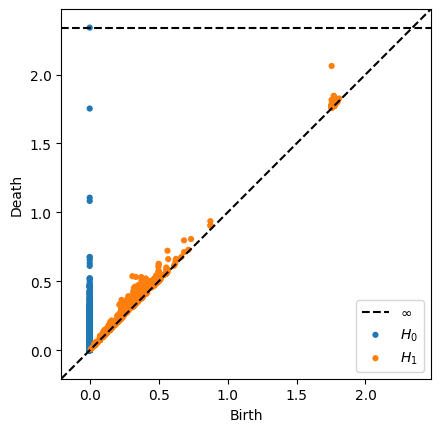

In [7]:
# Sample
X = df_tda.sample(n=2000, random_state=42).astype(float).values

# Persistent homology. Dims: 0 & 1
diagrams = ripser(X, maxdim=1)['dgms']

# Visualiza el diagrama de persistencia
plot_diagrams(diagrams, show=True)

* Most topological features are not very persistent (they born and die quickly), indicating that many patterns are likely noise.

* Some clusters (connected components) are persistent, which could indicate distinct groups of reservations.

* There are a persistent cycle, suggesting no dominant complex cyclic structures, but there could be some interesting circular clustering or repeating patterns.

#### Mapper Algorithm

In [20]:
# Sample
X = df_tda.sample(n=10000, random_state=42).astype(float).values

mapper = km.KeplerMapper(verbose=1)

# Define lens: first 2 components PCA
lens = PCA(n_components=2).fit_transform(X)

# Build graph
n_cubes = 10
overlap = 0.4

html_path = "mapper_reservaciones.html"

graph = mapper.map(lens,
                   X,
                   clusterer=DBSCAN(eps=0.2, min_samples=2),
                   cover=km.Cover(n_cubes=n_cubes, perc_overlap=overlap))

# Visualize graph
mapper.visualize(graph,
                 path_html=html_path,
                 title=f"Mapper: Reservaciones (Cubes={n_cubes}, Overlap={overlap})",
                 #color_values=X[:,0], # Nodes color
                 #color_function_name = 'X axis value',
                 node_color_function=np.array(['mean','median', 'var', 'std',
                                                'sum', 'max','min']),
                 include_searchbar=True # Search for a node
                 )

KeplerMapper(verbose=1)
Mapping on data shaped (10000, 28) using lens shaped (10000, 2)

Creating 100 hypercubes.

Created 1343 edges and 864 nodes in 0:00:02.263462.
Wrote visualization to: mapper_reservaciones.html


'<!DOCTYPE html>\n<html>\n\n<head>\n  <meta charset="utf-8">\n  <meta name="generator" content="KeplerMapper">\n  <title>Mapper: Reservaciones (Cubes=10, Overlap=0.4) | KeplerMapper</title>\n\n  <link rel="icon" type="image/png" href="http://i.imgur.com/axOG6GJ.jpg" />\n\n  <link href=\'https://fonts.googleapis.com/css?family=Roboto+Mono:700,300\' rel=\'stylesheet\' type=\'text/css\'>\n  <style>* {\n  margin: 0;\n  padding: 0;\n}\n\nhtml, body {\n  height: 100%;\n}\n\nbody {\n  font-family: "Roboto Mono", "Helvetica", sans-serif;\n  font-size: 14px;\n}\n\n#logo {\n  width:  85px;\n  height: 85px;\n}\n\n#display {\n  color: #95A5A6;\n  background: #212121;\n}\n\n#header {\n  background: #111111;\n}\n\n#print {\n  color: #000;\n  background: #FFF;\n}\n\nh1 {\n  font-size: 21px;\n  font-weight: 300;\n  font-weight: 300;\n}\n\nh2 {\n  font-size: 18px;\n  padding-bottom: 20px;\n  font-weight: 300;\n}\n\nh3 {\n  font-size: 14px;\n  font-weight: 700;\n  text-transform: uppercase;\n}\n\nh4 {\n

**Graph**

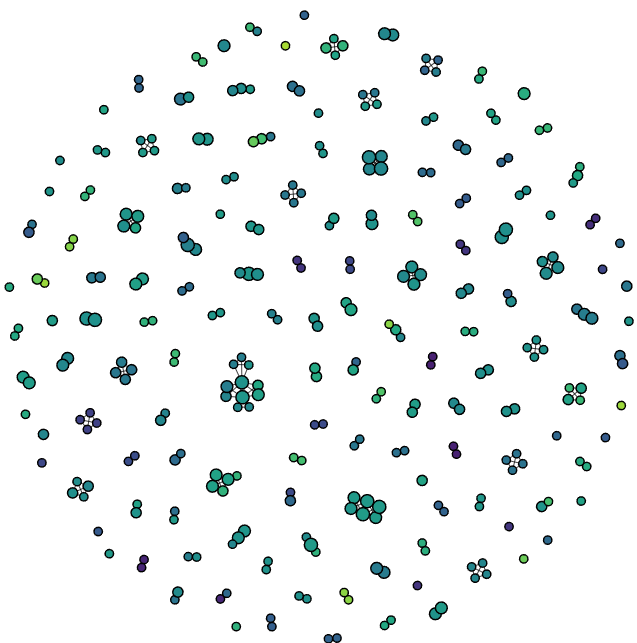

* There is no globally connected structure: under the filter function and the chosen parameters, teh data is grouped into many small, non-overlapping clusters.

* No paths, cycles, or large clusters are observed, suggesting that there are no complex topological patterns (such as rings or branches) in the projection used.

* The segmentation is very fine: we could experiment with Mapper parameters (more overlap, fewer cubes, less strict clustering) to look for larger clusters and connections.

#### Topological Features

* VietorisRipsPersistence
* Persistence Entropy

In [9]:
# Sample
X = df_tda.sample(n=2000, random_state=42).astype(float).values

# Reshape X to have an extra dimension for a single point cloud
X = X.reshape(1, *X.shape)  # or X[None, :, :]

# Initialize VietorisRipsPersistence
vr = VietorisRipsPersistence(homology_dimensions=[0, 1])

# Compute persistence diagrams
diagrams = vr.fit_transform(X)

# Initialize PersistenceEntropy
pe = PersistenceEntropy()

# Compute topological features (persistence entropy)
topological_features = pe.fit_transform(diagrams)

# Create a DataFrame for topological features
topological_df = pd.DataFrame(topological_features, columns=[f'PE_{i}' for i in range(topological_features.shape[1])])

# Concatenate topological features to the original dataframe
# df_tda_with_features = pd.concat([df_tda.sample(n=2000, random_state=42).reset_index(drop=True), topological_df.reset_index(drop=True)], axis=1)

topological_df

,PE_0,PE_1
0,10.065331,8.799289


Dimension 0 (PE_0) corresponds to the connected components (clusters). A high value (10.06) indicates that the distribution of the persistence of these clusters is quite dispersed, suggesting a complex structure with many clusters appearing and disappearing at different scales, with no clear dominance.

Dimension 1 (PE_1) corresponds to cycles or holes. A somewhat lower value (8.79) indicates that the topological complexity in terms of cycles is also significant, but less than that of the connected components. This may reflect the presence of cyclical patterns or loops in the data, but with less variety or dispersion than the connected components.

### 2. Apply PCA before TDA

Apply PCA to the original dataframe and do TDA

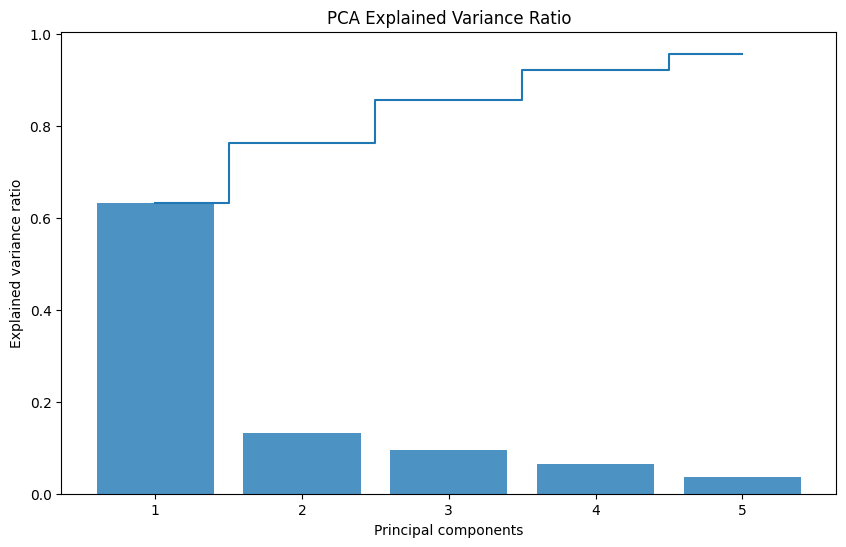

In [10]:
# Apply PCA
pca = PCA(n_components=5)  # Adjust the number of components as needed
pca_result = pca.fit_transform(df_tda)

# Explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_

# Create bar plot of principal components
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, alpha=0.8, align='center')
plt.step(range(1, len(explained_variance_ratio) + 1), np.cumsum(explained_variance_ratio), where='mid')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.title('PCA Explained Variance Ratio')
plt.show()


The first three components captures near the 90% of variance.

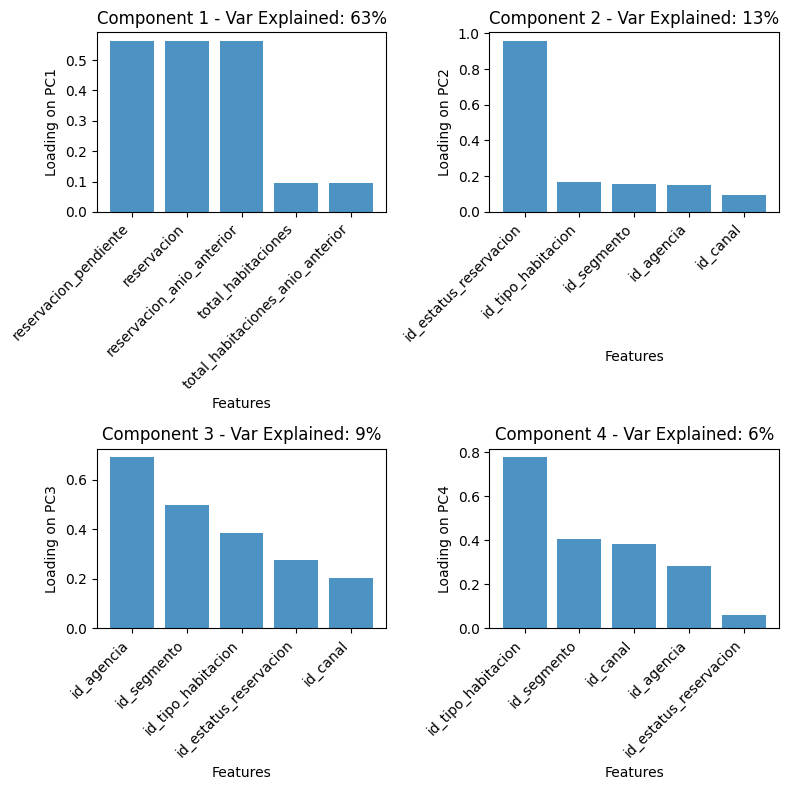

In [11]:
# Explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_

plt.subplots(2,2, figsize=(8, 8))
for i in range(4):

  # Get the loadings for the first principal component
  loadings = pca.components_[i]

  # Create a DataFrame to hold the loadings and feature names
  loadings_df = pd.DataFrame({'Feature': df_tda.columns, 'Loading': loadings})

  # Sort by absolute loading values (to consider both positive and negative contributions)
  loadings_df['Abs_Loading'] = loadings_df['Loading'].abs()
  top_5_loadings = loadings_df.nlargest(5, 'Abs_Loading')

  # Create the bar plot
  plt.subplot(2, 2, i+1)
  plt.bar(top_5_loadings['Feature'], top_5_loadings['Loading'].abs(), alpha=0.8, align='center')
  plt.xlabel('Features')
  plt.ylabel(f'Loading on PC{i+1}')
  plt.title(f'Component {i+1} - Var Explained: {round(explained_variance_ratio[i]*100)}%')
  plt.xticks(rotation=45, ha='right') # Rotate x-axis labels for better readability

plt.tight_layout() # Adjust layout to prevent labels from overlapping
plt.show()


The most significant variables are: `reservacion_pendiente`, `reservacion` and `reservacion_anio_anterior`. These ones are the most significants for the first component.

#### Persistent homology

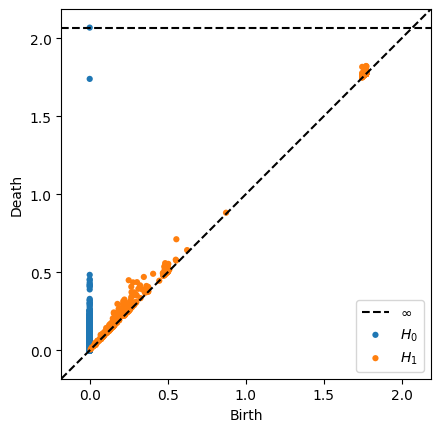

In [12]:
# Sample
pca = pca_result.copy()
pca = pd.DataFrame(pca)
X = pca.sample(n=2000, random_state=42).astype(float).values

# Persistent homology. Dims: 0 & 1
diagrams = ripser(X, maxdim=1)['dgms']

# Visualiza el diagrama de persistencia
plot_diagrams(diagrams, show=True)

We loosed our cycle and we have only one connected component.

#### Mapper Algorithm

In [13]:
# Sample
X = pca.sample(n=10000, random_state=42).astype(float).values

mapper = km.KeplerMapper(verbose=1)

# Define lens: first component
lens = PCA(n_components=2).fit_transform(X)

# Build graph
n_cubes = 10
overlap = 0.4

html_path = "mapper_reservaciones_pca.html"

graph = mapper.map(lens,
                   X,
                   clusterer=DBSCAN(eps=0.2, min_samples=2),
                   cover=km.Cover(n_cubes=n_cubes, perc_overlap=overlap))

# Visualize graph
mapper.visualize(graph,
                 path_html=html_path,
                 title=f"Mapper: Reservaciones (Cubes={n_cubes}, Overlap={overlap})",
                 #color_values=X[:,0], # Nodes color
                 #color_function_name = 'X axis value',
                 node_color_function=np.array(['mean','median', 'var', 'std',
                                                'sum', 'max','min']),
                 include_searchbar=True # Search for a node
                 )

KeplerMapper(verbose=1)
Mapping on data shaped (10000, 5) using lens shaped (10000, 2)

Creating 100 hypercubes.

Created 400 edges and 208 nodes in 0:00:01.217399.
Wrote visualization to: mapper_reservaciones_pca.html


'<!DOCTYPE html>\n<html>\n\n<head>\n  <meta charset="utf-8">\n  <meta name="generator" content="KeplerMapper">\n  <title>Mapper: Reservaciones (Cubes=10, Overlap=0.4) | KeplerMapper</title>\n\n  <link rel="icon" type="image/png" href="http://i.imgur.com/axOG6GJ.jpg" />\n\n  <link href=\'https://fonts.googleapis.com/css?family=Roboto+Mono:700,300\' rel=\'stylesheet\' type=\'text/css\'>\n  <style>* {\n  margin: 0;\n  padding: 0;\n}\n\nhtml, body {\n  height: 100%;\n}\n\nbody {\n  font-family: "Roboto Mono", "Helvetica", sans-serif;\n  font-size: 14px;\n}\n\n#logo {\n  width:  85px;\n  height: 85px;\n}\n\n#display {\n  color: #95A5A6;\n  background: #212121;\n}\n\n#header {\n  background: #111111;\n}\n\n#print {\n  color: #000;\n  background: #FFF;\n}\n\nh1 {\n  font-size: 21px;\n  font-weight: 300;\n  font-weight: 300;\n}\n\nh2 {\n  font-size: 18px;\n  padding-bottom: 20px;\n  font-weight: 300;\n}\n\nh3 {\n  font-size: 14px;\n  font-weight: 700;\n  text-transform: uppercase;\n}\n\nh4 {\n

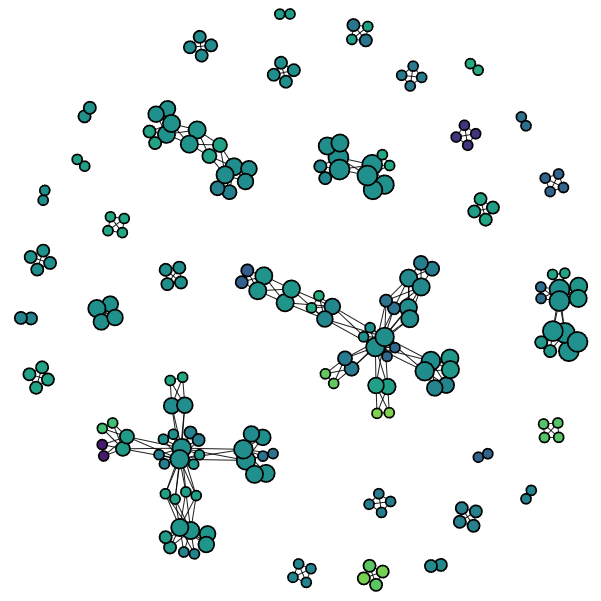

As expected, we reduced the amount of clusters and there are more groups of connected nodes. We can see more structures.

#### Topological Features

In [16]:
# Sample
X = pca.sample(n=2000, random_state=42).astype(float).values

# Reshape X to have an extra dimension for a single point cloud
X = X.reshape(1, *X.shape)  # or X[None, :, :]

# Initialize VietorisRipsPersistence
vr = VietorisRipsPersistence(homology_dimensions=[0, 1])

# Compute persistence diagrams
diagrams = vr.fit_transform(X)

# Initialize PersistenceEntropy
pe = PersistenceEntropy()

# Compute topological features (persistence entropy)
topological_features = pe.fit_transform(diagrams)

# Create a DataFrame for topological features
topological_df = pd.DataFrame(topological_features, columns=[f'PE_{i}' for i in range(topological_features.shape[1])])

# Concatenate topological features to the original dataframe
# df_tda_with_features = pd.concat([df_tda.sample(n=2000, random_state=42).reset_index(drop=True), topological_df.reset_index(drop=True)], axis=1)

topological_df

,PE_0,PE_1
0,9.766827,7.901911


The topological complexity has decreased in both dimensions.

Higher values = Higher topological complexity

## Final Comments


* Most topological features are not very persistent (they are born and die quickly), indicating that many patterns are likely noise.
* Some clusters (connected components) are persistent, which could indicate distinct groups of reservations.
* There is a persistent cycle, suggesting no dominant complex cyclical structures, but there could be some interesting circular groups or repeating patterns.
* We identified many clusters in mapper algorith, meaning that there are not complex structures in our dataset, and we have high diversity.
* We found some complex structures in PCA Mapper Algorithm, It is difficult to interpret.